In [48]:
###IMPORT PACKAGES
##
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re
from autoreject import AutoReject
from autoreject import Ransac
from autoreject import get_rejection_threshold
from mne.preprocessing import read_ica
from mne.preprocessing import ICA  # Ensure ICA is imported
from mne import read_epochs
from mne_icalabel import label_components
from mne_bids import BIDSPath, write_raw_bids
from mne_bids import write_raw_bids, BIDSPath

In [49]:
# Set the base project path

project_path = '/Users/admin/Documents/CodingBrain25/PreProcessing/'

# Define paths to each folder directly using the project path
raw_data_path = project_path + 'raw_data/'
raw_files_path = project_path + 'raw_files/'
epochs_uncleaned_path = project_path + 'uncleaned_epochs/'
ica_path = project_path + 'ICA_epochs/'
ica_figs_path = project_path + 'ICA_figs/'
ica_labels_path = project_path + 'ICA_label/'
ica_cleaned_path = project_path + 'ICA_clean/'
baseline_corrected_path = project_path + 'baseline_correct_epochs/'
ar_epochs_path = project_path + 'autoreject_epochs/'
evoked_path = project_path + 'Evokeds/'
grand_path = project_path + 'Grand_average/'
bids_path = project_path + 'bids_dataset/'
images_path = project_path + 'Individual_Plots/'

os.listdir('/Users/admin/Documents/CodingBrain25/PreProcessing/')



['bids_dataset',
 'ICA_epochs',
 'Preprocessing.ipynb',
 'autoreject_epochs',
 '.DS_Store',
 'raw_files',
 'Individual_Plots',
 'ICA_clean',
 'raw_data',
 'ICA_label',
 'uncleaned_epochs',
 '.venv',
 'Evokeds',
 'ICA_figs',
 'Grand_average',
 'baseline_correct_epochs']

In [50]:
subs = [f.replace('.bdf', '') for f in os.listdir(raw_data_path) if f.endswith('.bdf')]

subs

['0104-7VZA0',
 '0110-1IS78',
 '0109-GZN0K',
 '0107-FN3G3',
 '0128-HBQT4',
 '0122-BJDQI',
 '1217-SFP13',
 '0102-PV1XF',
 '0112-ZGZE5',
 '0108-U5RMG',
 '0114-9GG89',
 '0117-KXKZ2',
 '0104-SZEQ2',
 '0103-XN1WL',
 '0106-TZFW3',
 '0127-jpjw9']

In [51]:
# bad channels by Participants
bad_channels_dict = dict()
bad_channels_dict[subs[0]]= []
bad_channels_dict[subs[1]]= []
bad_channels_dict[subs[2]]= ['POz', 'P2']
bad_channels_dict[subs[3]]= ['Pz', 'P2']
bad_channels_dict[subs[4]]= []
bad_channels_dict[subs[5]]= ['O2', 'PO8']
bad_channels_dict[subs[6]]= ['P2']
bad_channels_dict[subs[7]]= []
bad_channels_dict[subs[8]]= []
bad_channels_dict[subs[9]]= []
bad_channels_dict[subs[10]]= ['F3', 'Fpz', 'FT7', 'P9', 'AF8', 'F6', 'FC5']
bad_channels_dict[subs[11]]= ['TP8', 'P4', 'T7']
bad_channels_dict[subs[12]]= ['Fp1', 'FC5', 'C3', 'CP5', 'P3', 'Fpz', 'FCz', 'C4', 'CP4']
bad_channels_dict[subs[13]]= ['Fp1', 'AF7']
bad_channels_dict[subs[14]]= ['F5', 'AF8', 'PO4']
bad_channels_dict[subs[15]]= ['C3', 'CP1', 'TP8', 'CP6', 'P10', 'PO4']

In [52]:
def load_and_process_raw(subject, raw_path, file_path, overwrite=True, save_events_as_annotations=True):
    raw_filename = file_path + subject + ".bdf"
    if not os.path.exists(raw_filename):
        raise FileNotFoundError(f"File {raw_filename} not found.")

    raw_save_path = raw_path + subject + '-raw.fif'
    
    if os.path.exists(raw_save_path) and not overwrite:
        print(f"Skipping {subject}: raw file already exists.")
        return None

    # Load raw data excluding EXG channels
    raw = mne.io.read_raw_bdf(raw_filename, preload=True, exclude=["EXG" + str(i) for i in range(1, 9)])

    # Apply band-pass filter
    raw_filtered = raw.filter(l_freq=1.0, h_freq=100.0)

    # Set montage
    montage = mne.channels.make_standard_montage('biosemi64')
    raw_filtered.set_montage(montage)
    raw_filtered.set_eeg_reference(["T7", "T8"])

    # Set bad channels from dictionary
    bad_channels = bad_channels_dict.get(subject, [])
    raw_filtered.info['bads'] = bad_channels


    # Find events with minimum duration
# Find events with a minimum duration of 5ms
    events = mne.find_events(raw_filtered, stim_channel='Status', initial_event=True, min_duration=0.005)
    # Print detected event IDs
    print("Detected Event IDs:", np.unique(events[:, 2]))

    # Filter events to include only expected event codes
    expected_event_ids = [32, 33, 34, 42, 43, 44, 52, 53, 54, 100, 101]
    filtered_events = events[np.isin(events[:, 2], expected_event_ids)]
    print(f"Number of valid events after filtering: {len(filtered_events)}")

    # Reclassification of events
    congruent_codes = [32, 33, 34]
    incongruent_codes = [52, 53, 54]
    correct_code = 100
    sample_window = int(20000 / 1000 * raw_filtered.info['sfreq'])  # 20-second window

    reclassified_events = []
    for i, event in enumerate(filtered_events):
        if event[2] in congruent_codes or event[2] in incongruent_codes:
            for j in range(i + 1, len(filtered_events)):
                if filtered_events[j, 0] - event[0] > sample_window:
                    break
                if filtered_events[j, 2] == correct_code:
                    new_code = 200 if event[2] in congruent_codes else 201
                    reclassified_events.append([event[0], event[1], new_code])
                    break

    reclassified_events = np.array(reclassified_events)

    # Create annotations from reclassified events
    event_desc = {200: 'congruent', 201: 'incongruent'}
    annotations = mne.annotations_from_events(reclassified_events, event_desc=event_desc,
                                              sfreq=raw_filtered.info['sfreq'], orig_time=raw_filtered.info['meas_date'])
    raw_filtered.set_annotations(annotations)

    raw_filtered.resample(200)

    # Save the processed raw file
    if overwrite:
        if os.path.exists(raw_save_path):
            os.remove(raw_save_path)
    raw_filtered.save(raw_save_path, overwrite=True)

    print(f"Saved raw data for {subject} at {raw_save_path}")
    return raw_filtered

In [53]:
raw = [
    load_and_process_raw(
        subject,
        file_path=raw_data_path,
        raw_path=raw_files_path,
        overwrite=False
    )
    for subject in subs
]

Skipping 0104-7VZA0: raw file already exists.
Skipping 0110-1IS78: raw file already exists.
Skipping 0109-GZN0K: raw file already exists.
Skipping 0107-FN3G3: raw file already exists.
Extracting EDF parameters from /Users/admin/Documents/CodingBrain25/PreProcessing/raw_data/0128-HBQT4.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4913151  =      0.000 ...  2399.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    4.1s


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
583 events found on stim channel Status
Event IDs: [   32    33    34    42    43    44    52    53    54   100   101   128
   228 65536]
Detected Event IDs: [   32    33    34    42    43    44    52    53    54   100   101   128
   228 65536]
Number of valid events after filtering: 578
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
582 events found on stim channel Status
Event IDs: [   32    33    34    42    43    44    52    53    54   100   101   128
   228 65536]
Trigger channel Status has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
582 events found on stim channel Status
Event IDs: [   32    33    34    42    43    44    52    53    54   100   101   128
   228 65536]
Writin

In [54]:
def run_ica(subject, raw_path, save_ica,  overwrite=False, method='infomax'):
    """
    Run ICA on the provided subject's raw data using specified ICA method, applying rejection thresholds and saving the ICA solution.

    Parameters:
    subject (str): Subject identifier.
    epoch_path (str): Path to the folder containing the epoch file.
    save_ica (str): Path to save the ICA file.
    overwrite (bool): If True, overwrite the existing ICA file. Default is True.
    method (str): ICA method to use ('fastica', 'infomax', 'extended-infomax'). Default is 'extended-infomax'.

    Returns:
    ICA: The fitted ICA object if processing is done, otherwise None.
    """

    # Define file paths
    raw_file_path = os.path.join(raw_path, f"{subject}-raw.fif")
    ica_file_path = os.path.join(save_ica, f"{subject}-ica.fif")

    # Check if the ICA file already exists and skip if overwrite is False
    if os.path.exists(ica_file_path) and not overwrite:
        print(f"ICA file already exists for {subject}. Skipping ICA computation.")
        return None  # Early exit if file exists and overwrite is False

    # Load the epochs file
    if not os.path.exists(raw_file_path):
        raise FileNotFoundError(f"raw file for {subject} not found at {raw_file_path}.")

    raw = mne.io.read_raw_fif(raw_file_path, preload=True)

    # Initialize and fit ICA using the specified method
    ica = ICA(
    n_components=15,
    max_iter="auto",
    method="infomax",
    random_state=97,
    fit_params=dict(extended=True)
)
    ica.fit(raw)

    # Save the ICA solution
    ica.save(ica_file_path, overwrite=overwrite)  # Pass overwrite to ica.save()
    print(f"ICA solution saved for {subject} at {ica_file_path}.")

    return ica

In [55]:
# Process each subject
for subject in subs:
    print(f"Running ICA for subject {subject}")
    run_ica(subject=subject, raw_path=raw_files_path, save_ica=ica_path, overwrite=False)

Running ICA for subject 0104-7VZA0
ICA file already exists for 0104-7VZA0. Skipping ICA computation.
Running ICA for subject 0110-1IS78
ICA file already exists for 0110-1IS78. Skipping ICA computation.
Running ICA for subject 0109-GZN0K
ICA file already exists for 0109-GZN0K. Skipping ICA computation.
Running ICA for subject 0107-FN3G3
ICA file already exists for 0107-FN3G3. Skipping ICA computation.
Running ICA for subject 0128-HBQT4
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0128-HBQT4-raw.fif...
    Range : 0 ... 479799 =      0.000 ...  2398.995 secs
Ready.
Reading 0 ... 479799  =      0.000 ...  2398.995 secs...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 15 components
Computing Extended Infomax ICA
Fitting ICA took 48.6s.
Writing ICA solution to /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0128-HBQT4-ica.fif...
ICA solution saved for 0128-HBQT4 at /Users/admin/Docume

In [56]:

def plot_ica(subject, ica_path, save_plots, ica_plot_path, overwrite=False):
    """
    Plots ICA components and saves each figure if specified.

    Parameters:
    subject (str): Subject identifier.
    ica_path (str): Path to load the ICA file.
    save_plots (bool): If True, saves the plot of ICA components.
    ica_plot_path (str): Path to save the ICA component plots.
    """

    # Load ICA solutions from file
    ica = read_ica(os.path.join(ica_path, subject + "-ica.fif"))

    # Plot ICA components
    ica_figures = ica.plot_components()

    if save_plots:
        if isinstance(ica_figures, list):  # Case when multiple figures are returned
            for i, fig in enumerate(ica_figures):
                save_path = os.path.join(ica_plot_path, f"{subject}_ica_components_page_{i+1}.pdf")
                if os.path.exists(save_path) and not overwrite:
                    print(f"Skipping {subject}: raw file already exists.")
                    return
                fig.savefig(save_path, dpi=600)
                print(f"Figure {i+1} for subject {subject} saved at {save_path}")
        else:  # Case when a single figure is returned
            save_path = os.path.join(ica_plot_path, f"{subject}_ica_components.pdf")
            if os.path.exists(save_path) and not overwrite:
                    print(f"Skipping {subject}: raw file already exists.")
                    return
            ica_figures.savefig(save_path, dpi=600)
            print(f"Figure for subject {subject} saved at {save_path}")
    else:
        print('Not saving plots; set "save_plots" to "True" to save')



Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0104-7VZA0-ica.fif ...
Now restoring ICA solution ...
Ready.


<Figure size 640x480 with 0 Axes>

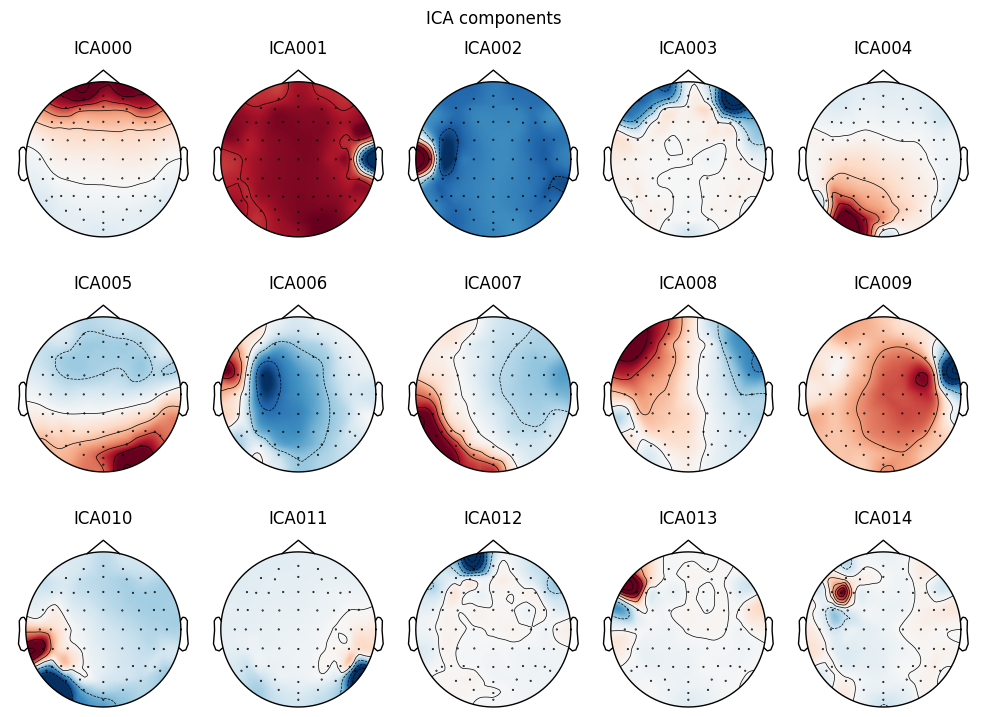

Skipping 0104-7VZA0: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0110-1IS78-ica.fif ...
Now restoring ICA solution ...
Ready.


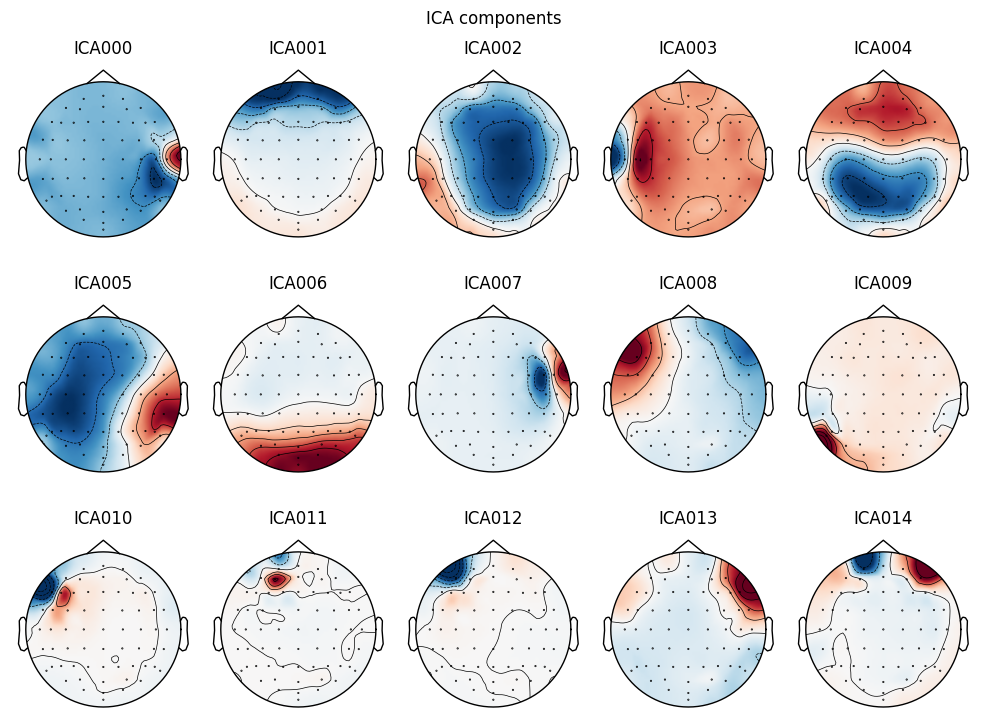

Skipping 0110-1IS78: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0109-GZN0K-ica.fif ...
Now restoring ICA solution ...
Ready.


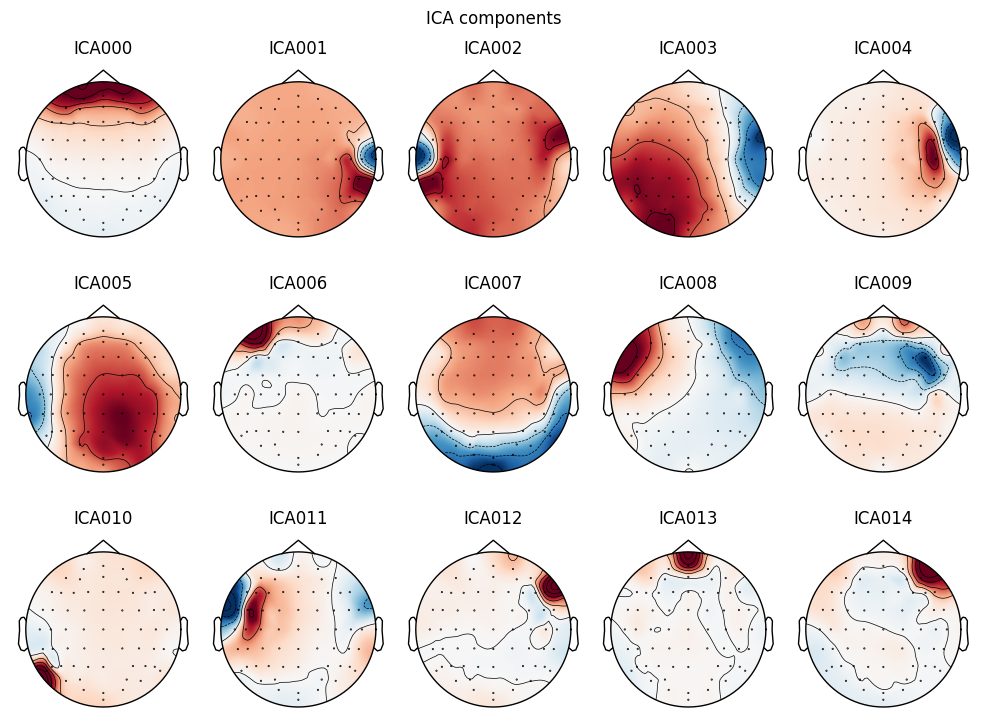

Skipping 0109-GZN0K: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0107-FN3G3-ica.fif ...
Now restoring ICA solution ...
Ready.


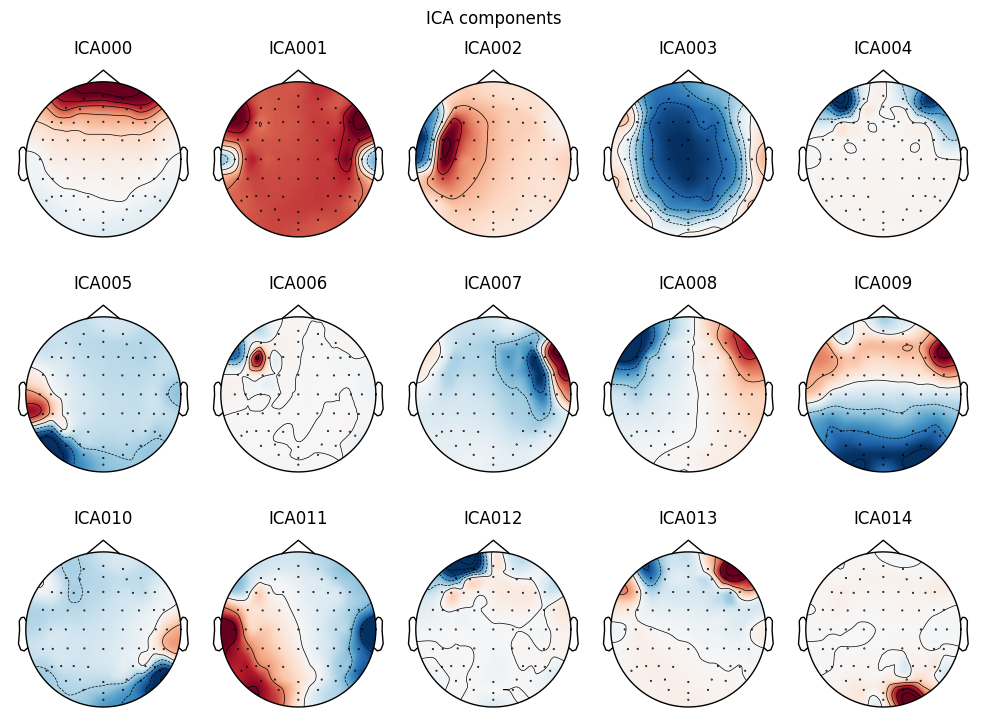

Skipping 0107-FN3G3: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0128-HBQT4-ica.fif ...
Now restoring ICA solution ...
Ready.


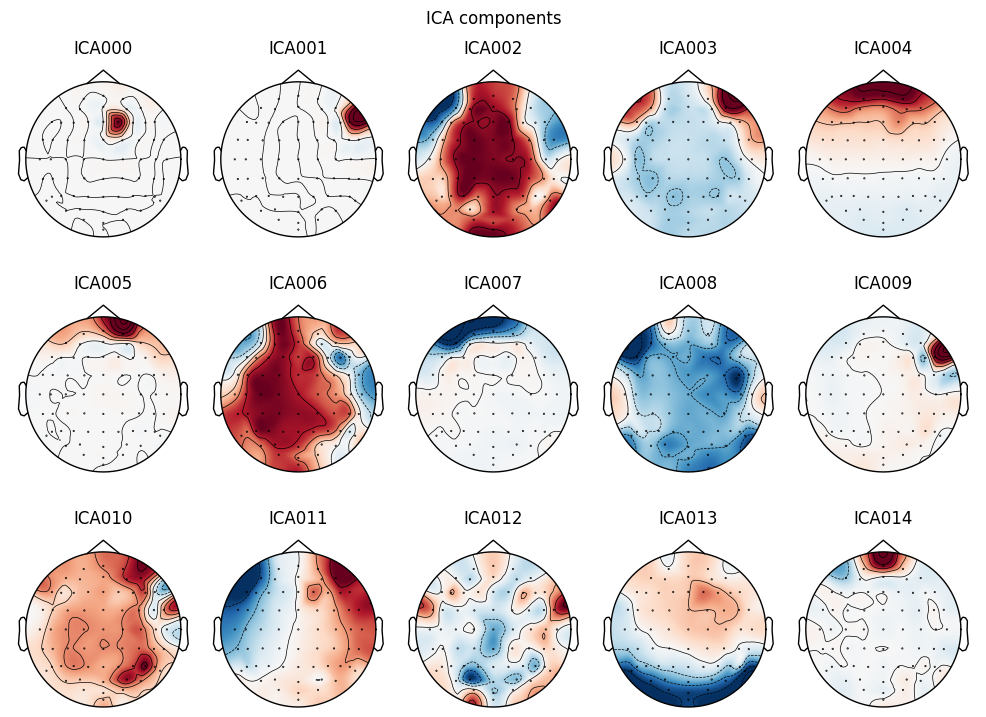

Figure for subject 0128-HBQT4 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_figs/0128-HBQT4_ica_components.pdf
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0122-BJDQI-ica.fif ...
Now restoring ICA solution ...
Ready.


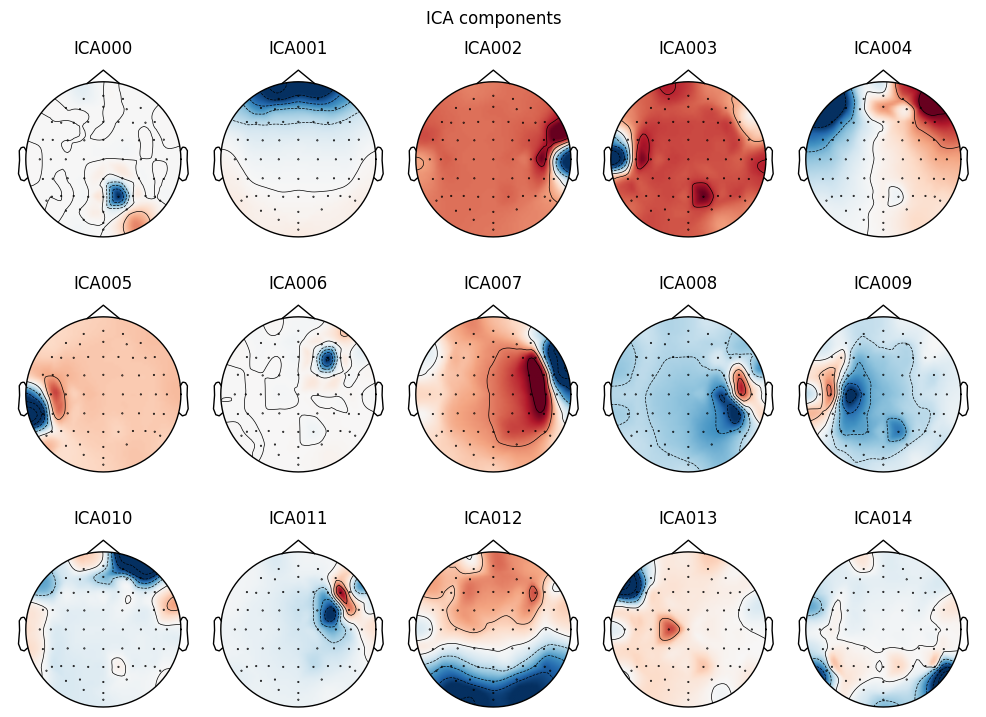

Skipping 0122-BJDQI: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/1217-SFP13-ica.fif ...
Now restoring ICA solution ...
Ready.


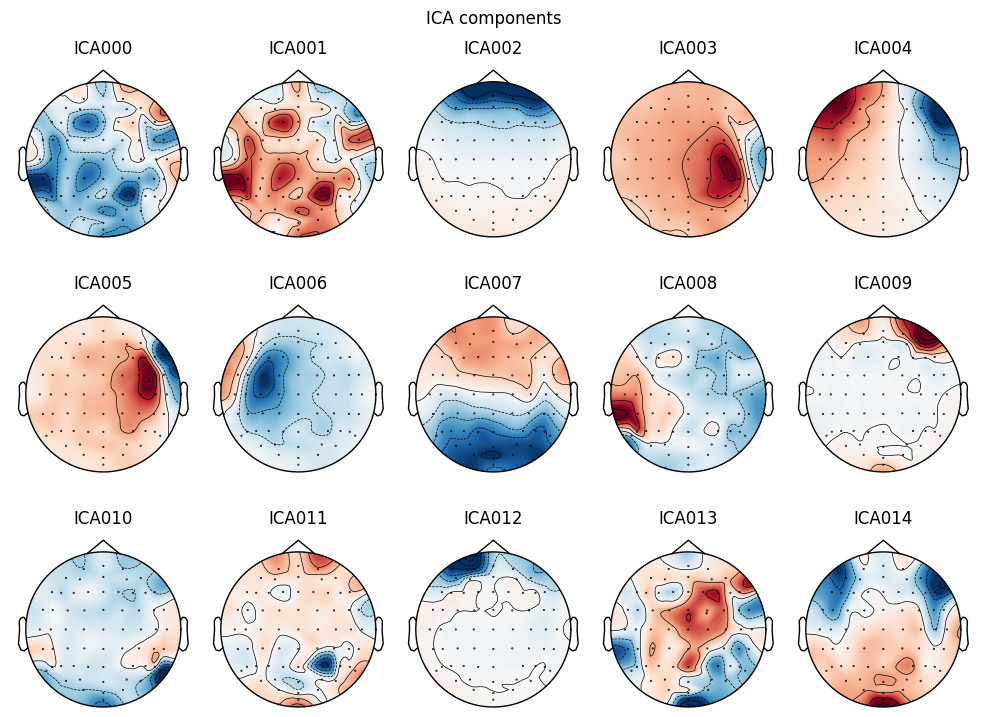

Skipping 1217-SFP13: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0102-PV1XF-ica.fif ...
Now restoring ICA solution ...
Ready.


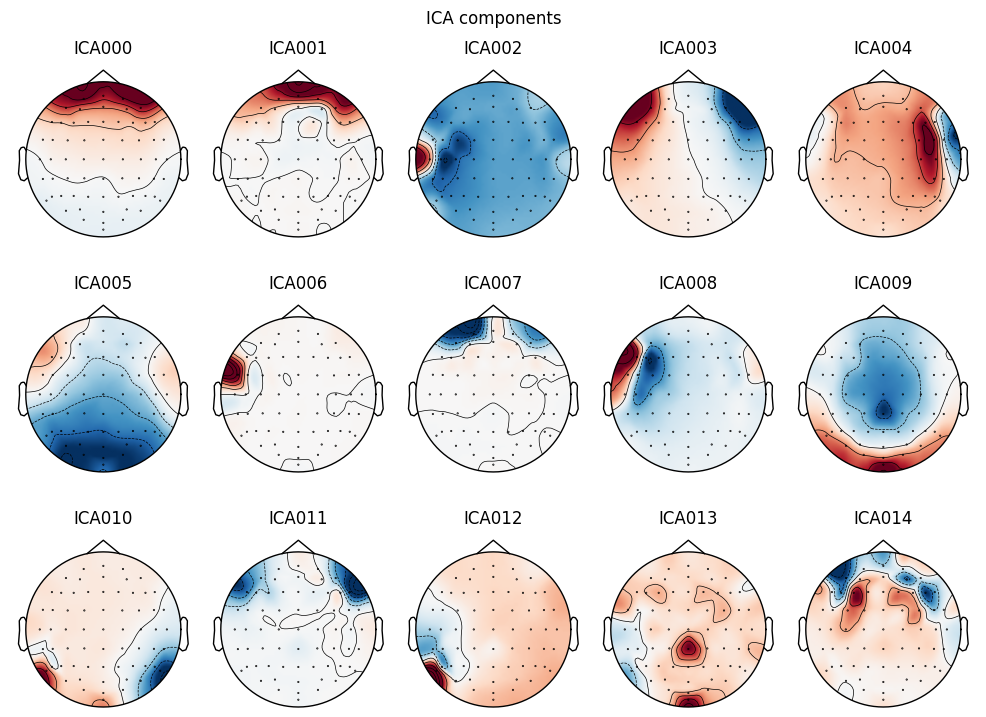

Skipping 0102-PV1XF: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0112-ZGZE5-ica.fif ...
Now restoring ICA solution ...
Ready.


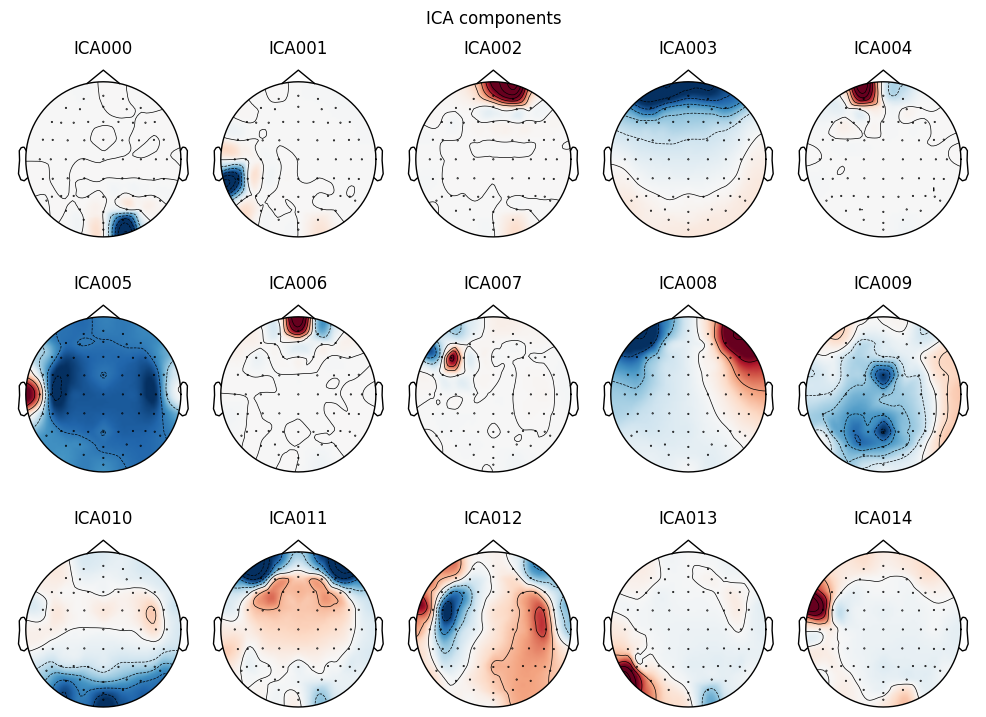

Skipping 0112-ZGZE5: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0108-U5RMG-ica.fif ...
Now restoring ICA solution ...
Ready.


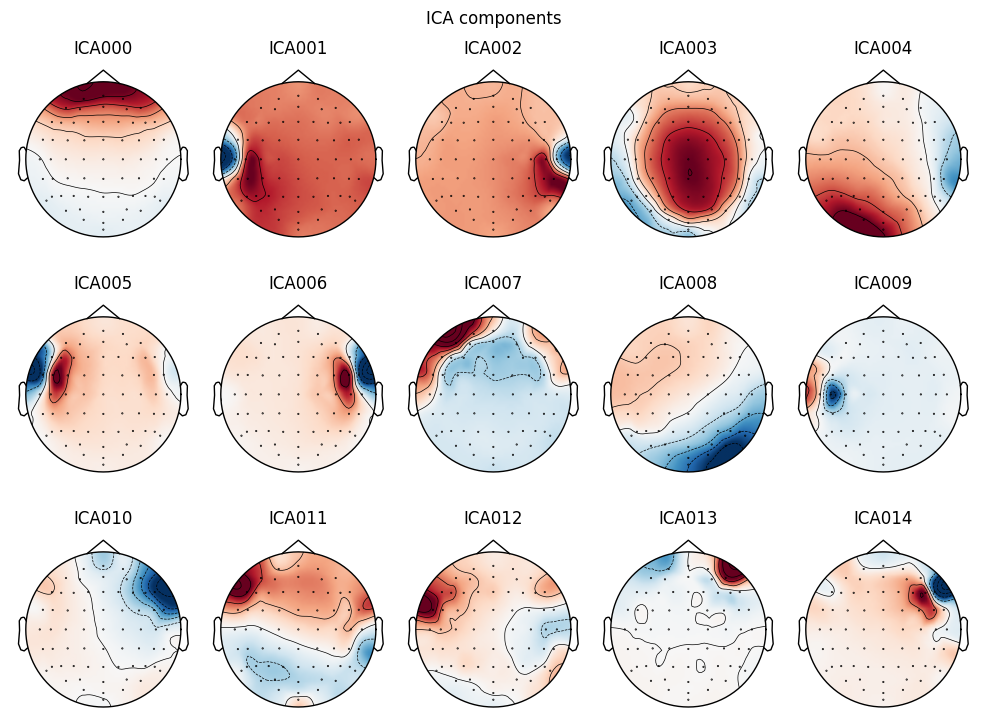

Skipping 0108-U5RMG: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0114-9GG89-ica.fif ...
Now restoring ICA solution ...
Ready.


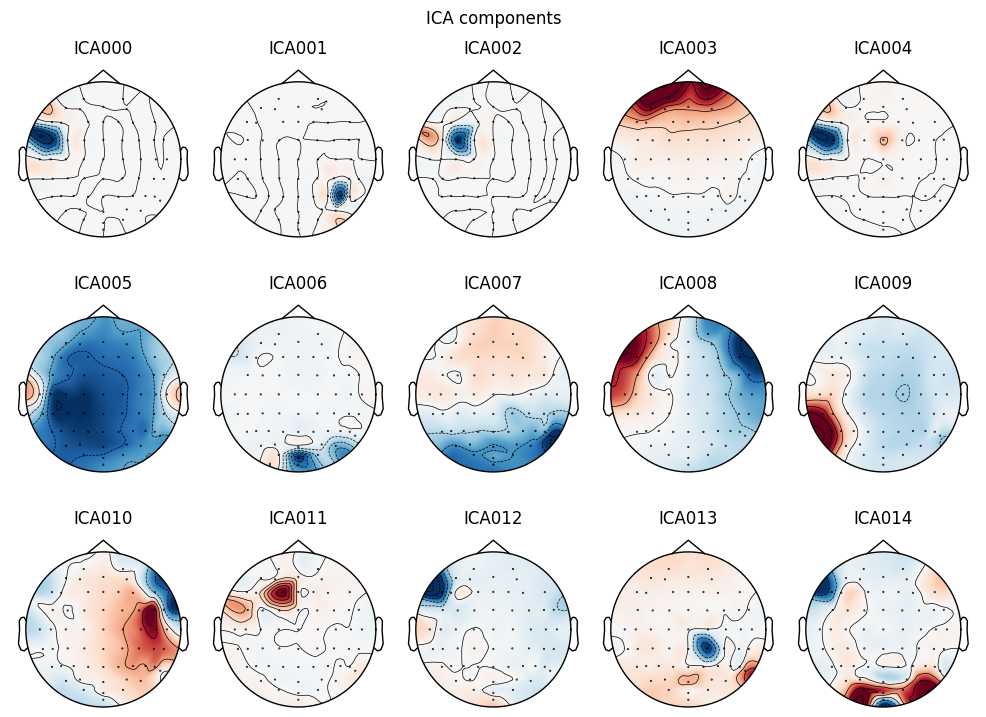

Skipping 0114-9GG89: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0117-KXKZ2-ica.fif ...
Now restoring ICA solution ...
Ready.


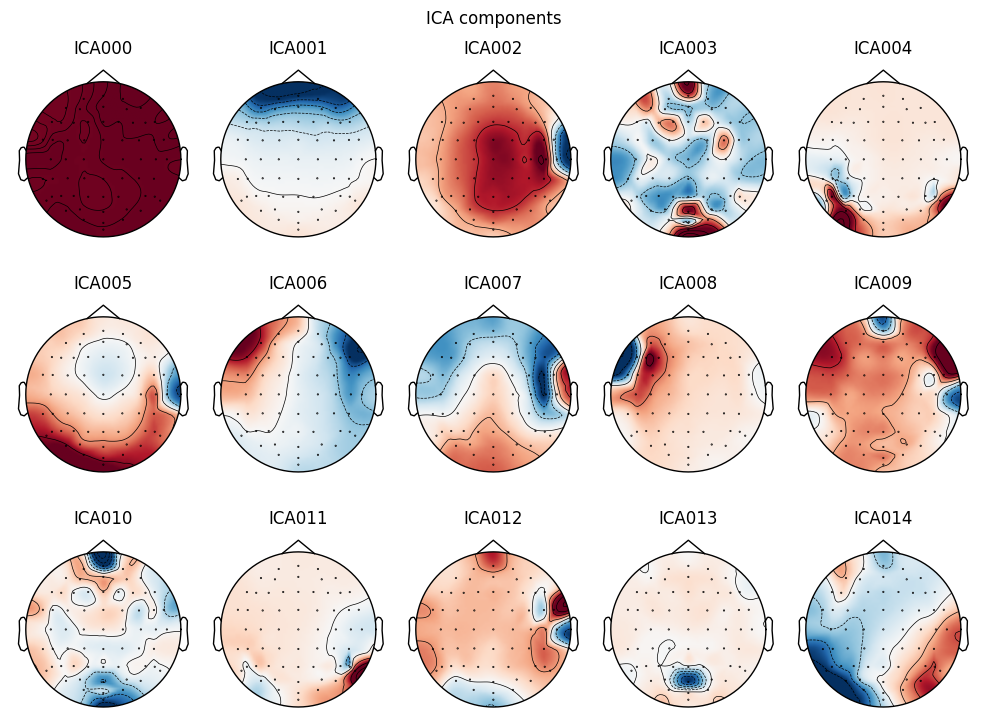

Skipping 0117-KXKZ2: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0104-SZEQ2-ica.fif ...
Now restoring ICA solution ...
Ready.


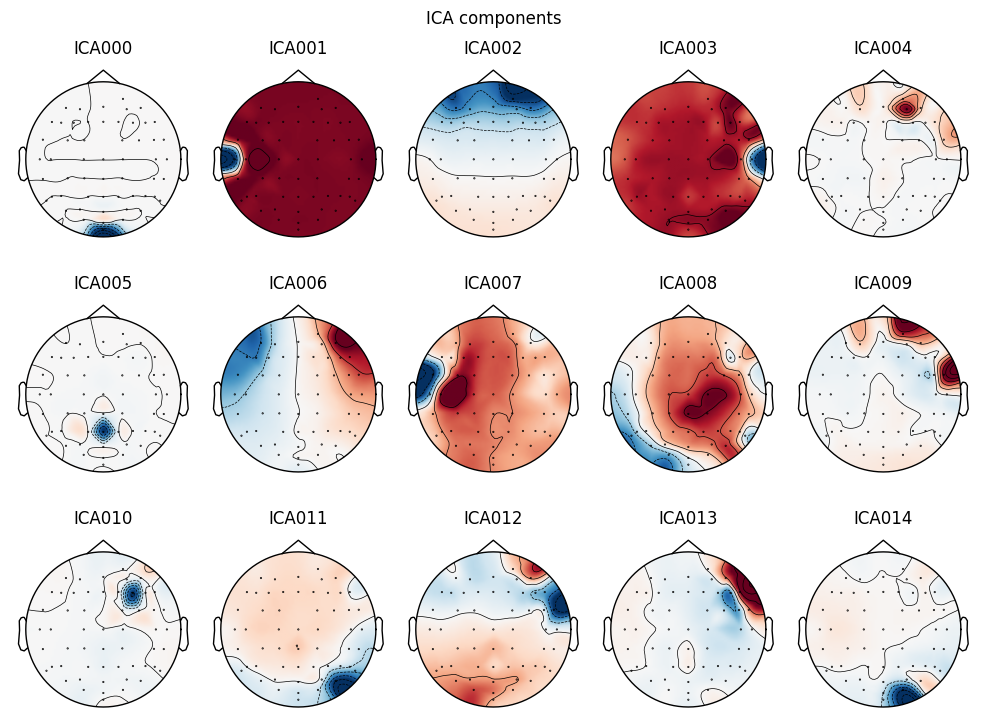

Skipping 0104-SZEQ2: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0103-XN1WL-ica.fif ...
Now restoring ICA solution ...
Ready.


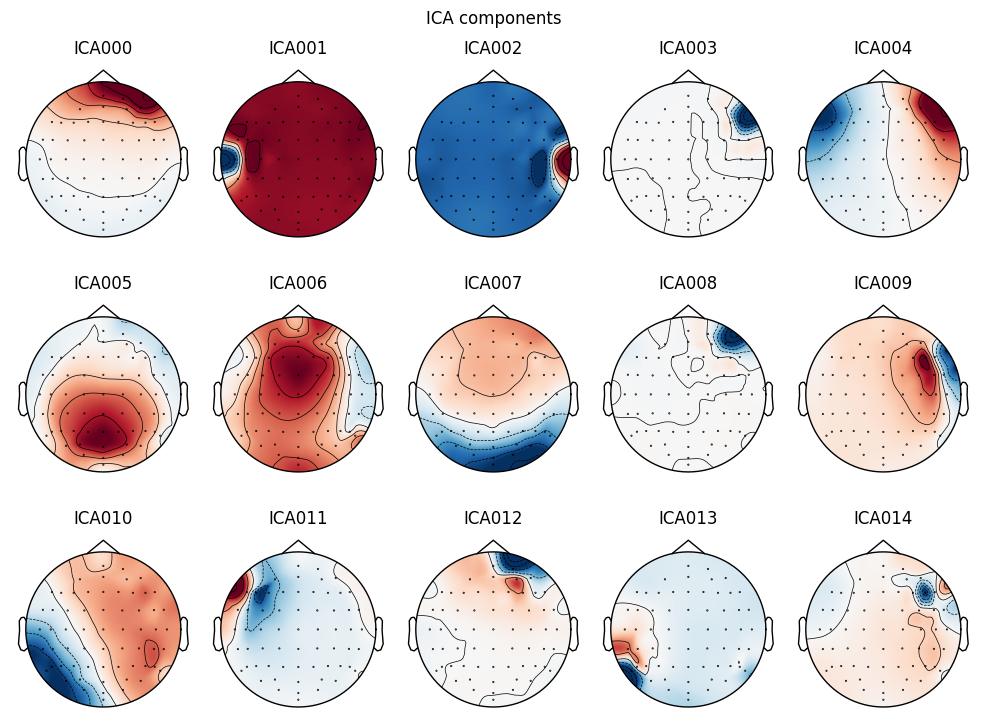

Skipping 0103-XN1WL: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0106-TZFW3-ica.fif ...
Now restoring ICA solution ...
Ready.


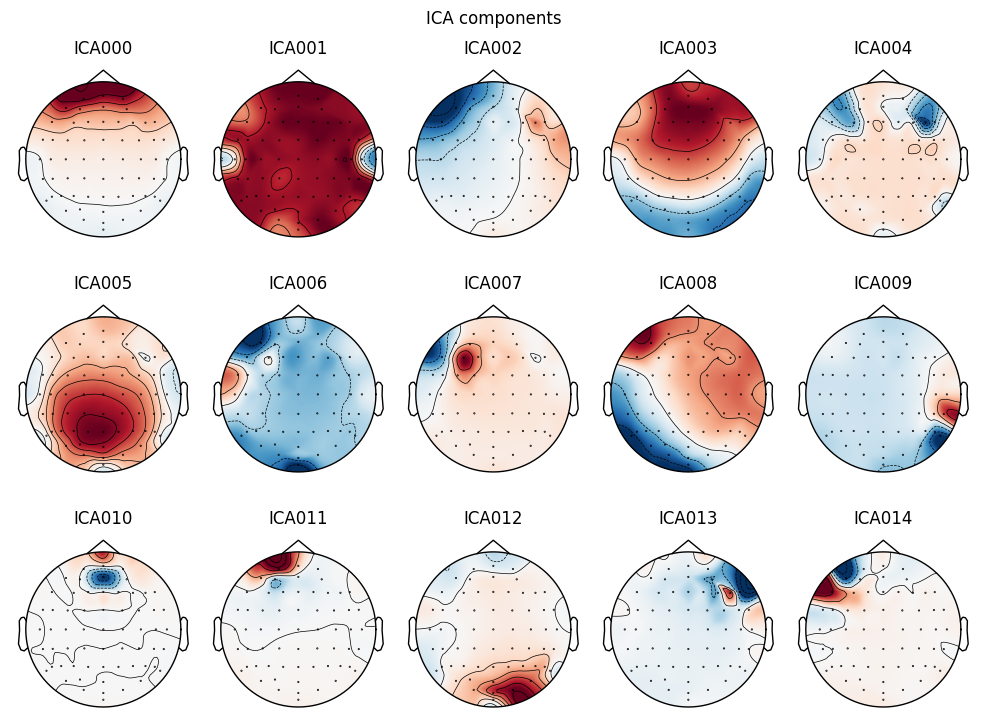

Skipping 0106-TZFW3: raw file already exists.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0127-jpjw9-ica.fif ...
Now restoring ICA solution ...
Ready.


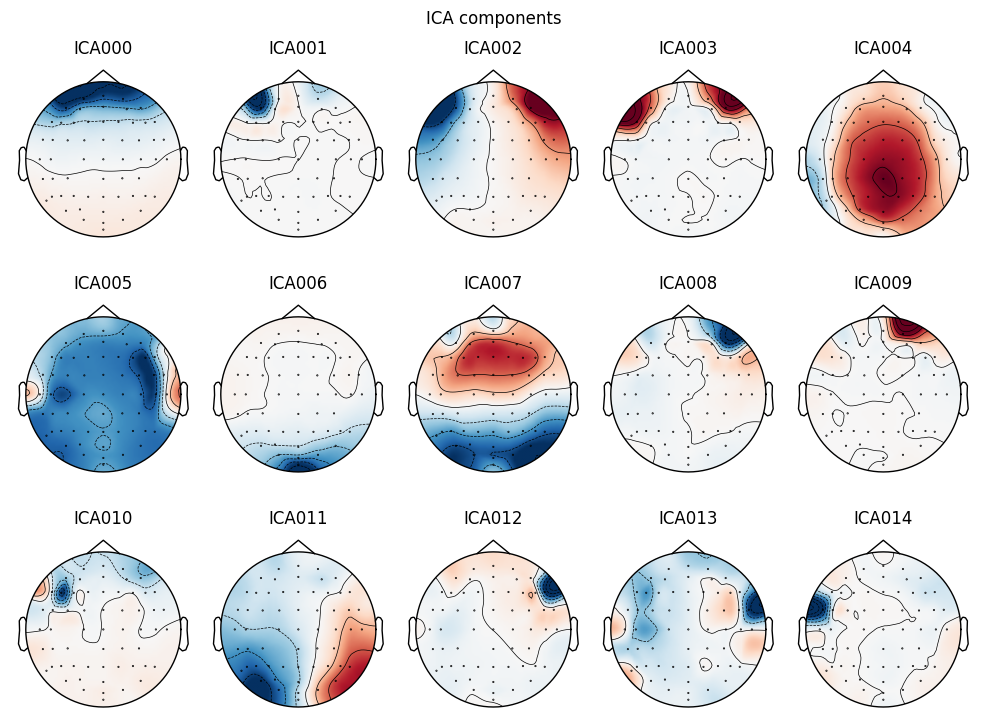

Skipping 0127-jpjw9: raw file already exists.


In [57]:
# Example usage for multiple subjects
for subject in subs:
    plot_ica(subject, ica_path=ica_path, save_plots=True, ica_plot_path=ica_figs_path, overwrite=False)

In [58]:

def classify_and_apply_ica(subject, raw_path, ica_path, ica_label_path, ica_cleaned_path,  print_labels=True):
    """
    Load epochs and ICA files, classify ICA components using ICLabel, save the labels as a CSV file,
    mark bad components for exclusion, apply ICA to clean the epochs, and save the cleaned epochs.

    Parameters:
    subject (str): Subject identifier.
    epochs_path (str): Directory path to load the epochs file.
    ica_path (str): Directory path to load the ICA file.
    save_path (str): Directory path to save the labels CSV file and cleaned epochs.
    print_labels (bool): If True, prints the classification labels and exclusion indices. Default is True.

    Returns:
    dict: Dictionary containing the classification results.
    list: List of indices of components to exclude.
    mne.Epochs: The cleaned epochs after applying ICA.
    """

    # Load epochs and ICA files
    raw_file = os.path.join(raw_path, f"{subject}-raw.fif")
    ica_file = os.path.join(ica_path, f"{subject}-ica.fif")

    if not os.path.exists(raw_file):
        raise FileNotFoundError(f"raw file for subject {subject} not found at {raw_file}.")
    if not os.path.exists(ica_file):
        raise FileNotFoundError(f"ICA file for subject {subject} not found at {ica_file}.")

    raw =  mne.io.read_raw_fif(raw_file, preload=True)


    ica = read_ica(ica_file)

    # Apply ICLabel to classify components

    #ica_channels = ica_channels_dict[subject]# in

    labels = label_components(raw, ica, method="iclabel")

   # Extract label names and identify indices to exclude
    labels = labels["labels"]
    exclude_idx = [
        idx for idx, label in enumerate(labels) if label not in ["brain", "other"]
    ]
    if print_labels:
        print(f"Excluding these ICA components: {exclude_idx}")

    # Mark bad components for exclusio

    ica.exclude += exclude_idx

    # Apply the ICA solution to remove the bad components from epochs
    raw_clean = ica.apply(raw.copy())  # Apply ICA on a copy of the epochs

    raw_clean.filter(.1, 40, fir_design='firwin') #for ICA filter between 1

    epochs = mne.Epochs(raw_clean, tmin=-0.2, tmax=1, baseline=None, preload=True, reject=None)

    # Save the cleaned epochs
    cleaned_epochs_file = os.path.join(ica_cleaned_path, f"{subject}_clean-epo.fif")
    epochs.save(cleaned_epochs_file, overwrite=True)
    print(f"Cleaned epochs for subject {subject} saved at {cleaned_epochs_file}")

    # Convert labels dictionary to a DataFrame
   # label_data = []
  #  for idx, label in enumerate(labels):
   #     label_data.append({'Component': idx, 'Label': label})

   # labels_df = pd.DataFrame(label_data)

    # Save labels to CSV
   # csv_save_path = os.path.join(ica_label_path, f"{subject}_ica_labels.csv")
   # labels_df.to_csv(csv_save_path, index=False)
   # print(f"Labels for subject {subject} saved at {csv_save_path}")

    # Optional: Print labels for inspection
  #  if print_labels:
  #      print(labels)

    return epochs

epochs_cleaned = [classify_and_apply_ica(subject, raw_path=raw_files_path, ica_path=ica_path, ica_label_path=ica_labels_path, ica_cleaned_path=ica_cleaned_path, print_labels=True) for subject in subs]


Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0104-7VZA0-raw.fif...
    Range : 0 ... 380399 =      0.000 ...  1901.995 secs
Ready.
Reading 0 ... 380399  =      0.000 ...  1901.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0104-7VZA0-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 11 ICA components
    Projecting back using 64 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- U

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 290 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0104-7VZA0 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0104-7VZA0_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0110-1IS78-raw.fif...
    Range : 0 ... 434599 =      0.000 ...  2172.995 secs
Ready.
Reading 0 ... 434599  =      0.000 ...  2172.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0110-1IS78-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [1, 7, 8, 10, 11, 12, 13, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 8 ICA components
  

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 290 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0110-1IS78 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0110-1IS78_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0109-GZN0K-raw.fif...
    Range : 0 ... 405599 =      0.000 ...  2027.995 secs
Ready.
Reading 0 ... 405599  =      0.000 ...  2027.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0109-GZN0K-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 3, 4, 5, 6, 8, 9, 10, 11, 13]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 11 ICA compo

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 291 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0109-GZN0K saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0109-GZN0K_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0107-FN3G3-raw.fif...
    Range : 0 ... 426399 =      0.000 ...  2131.995 secs
Ready.
Reading 0 ... 426399  =      0.000 ...  2131.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0107-FN3G3-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 4, 5, 6, 7, 8, 12, 13]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 9 ICA components
  

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 291 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0107-FN3G3 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0107-FN3G3_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0128-HBQT4-raw.fif...
    Range : 0 ... 479799 =      0.000 ...  2398.995 secs
Ready.
Reading 0 ... 479799  =      0.000 ...  2398.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0128-HBQT4-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 4, 5, 7, 9, 11]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 7 ICA components
    Proje

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 291 events and 241 original time points ...
0 bad epochs dropped
Cleaned epochs for subject 0128-HBQT4 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0128-HBQT4_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0122-BJDQI-raw.fif...
    Range : 0 ... 450999 =      0.000 ...  2254.995 secs
Ready.
Reading 0 ... 450999  =      0.000 ...  2254.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0122-BJDQI-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 4, 5, 6, 7, 8, 10, 11, 13, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 11 ICA components
    Projecting back using 62 PCA components
Fil

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 291 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0122-BJDQI saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0122-BJDQI_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/1217-SFP13-raw.fif...
    Range : 0 ... 412399 =      0.000 ...  2061.995 secs
Ready.
Reading 0 ... 412399  =      0.000 ...  2061.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/1217-SFP13-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [2, 3, 4, 5, 9, 10, 11, 12, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 9 ICA components


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
282 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 282 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 1217-SFP13 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/1217-SFP13_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0102-PV1XF-raw.fif...
    Range : 0 ... 439999 =      0.000 ...  2199.995 secs
Ready.
Reading 0 ... 439999  =      0.000 ...  2199.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0102-PV1XF-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 2, 3, 4, 6, 7, 8, 10, 11]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 10 ICA component

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 291 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0102-PV1XF saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0102-PV1XF_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0112-ZGZE5-raw.fif...
    Range : 0 ... 379399 =      0.000 ...  1896.995 secs
Ready.
Reading 0 ... 379399  =      0.000 ...  1896.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0112-ZGZE5-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 2, 3, 4, 6, 7, 8, 9, 11, 13]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 11 ICA compon

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 291 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0112-ZGZE5 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0112-ZGZE5_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0108-U5RMG-raw.fif...
    Range : 0 ... 402999 =      0.000 ...  2014.995 secs
Ready.
Reading 0 ... 402999  =      0.000 ...  2014.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0108-U5RMG-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 4, 5, 6, 7, 9, 10, 12, 13, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 11 ICA comp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 290 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0108-U5RMG saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0108-U5RMG_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0114-9GG89-raw.fif...
    Range : 0 ... 470199 =      0.000 ...  2350.995 secs
Ready.
Reading 0 ... 470199  =      0.000 ...  2350.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0114-9GG89-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 2, 3, 4, 8, 11]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 7 ICA components
    Proje

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 290 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0114-9GG89 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0114-9GG89_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0117-KXKZ2-raw.fif...
    Range : 0 ... 442599 =      0.000 ...  2212.995 secs
Ready.
Reading 0 ... 442599  =      0.000 ...  2212.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0117-KXKZ2-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 6, 8, 11, 13]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 6 ICA components
    Project

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 291 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0117-KXKZ2 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0117-KXKZ2_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0104-SZEQ2-raw.fif...
    Range : 0 ... 411399 =      0.000 ...  2056.995 secs
Ready.
Reading 0 ... 411399  =      0.000 ...  2056.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0104-SZEQ2-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [2, 4, 5, 6, 8, 9, 10, 11, 13]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 9 ICA components
 

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.5s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
289 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 289 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0104-SZEQ2 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0104-SZEQ2_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0103-XN1WL-raw.fif...
    Range : 0 ... 431799 =      0.000 ...  2158.995 secs
Ready.
Reading 0 ... 431799  =      0.000 ...  2158.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0103-XN1WL-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 3, 4, 8, 9, 11, 12, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 8 ICA components
    

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 291 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0103-XN1WL saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0103-XN1WL_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0106-TZFW3-raw.fif...
    Range : 0 ... 360599 =      0.000 ...  1802.995 secs
Ready.
Reading 0 ... 360599  =      0.000 ...  1802.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0106-TZFW3-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 2, 6, 7, 9, 11, 13, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 8 ICA components
    

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 280 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0106-TZFW3 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0106-TZFW3_clean-epo.fif
Opening raw data file /Users/admin/Documents/CodingBrain25/PreProcessing/raw_files/0127-jpjw9-raw.fif...
    Range : 0 ... 378399 =      0.000 ...  1891.995 secs
Ready.
Reading 0 ... 378399  =      0.000 ...  1891.995 secs...
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_epochs/0127-jpjw9-ica.fif ...
Now restoring ICA solution ...
Ready.
Excluding these ICA components: [0, 1, 2, 3, 6, 8, 9, 10, 11, 12, 14]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 11 ICA comp

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s


Used Annotations descriptions: [np.str_('congruent'), np.str_('incongruent')]
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 290 events and 241 original time points ...
0 bad epochs dropped
Overwriting existing file.
Overwriting existing file.
Cleaned epochs for subject 0127-jpjw9 saved at /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0127-jpjw9_clean-epo.fif


In [63]:
#baseline correct the data
def prepro_epoch_new(subject, save_path, file_path, overwrite):
     epoch_file=mne.read_epochs(file_path + subject + '_' + 'clean'+'-epo.fif')
     epoch_file.apply_baseline((-.2,0))
     epoch_file.save(save_path + subject+ 'apply_baseline'+'-epo.fif', overwrite=overwrite)
     return(epoch_file)


In [65]:
clean = [prepro_epoch_new(subject, save_path=baseline_corrected_path, file_path=ica_cleaned_path, overwrite=True) for subject in subs]

Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0104-7VZA0_clean-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Overwriting existing file.
Overwriting existing file.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0110-1IS78_clean-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Applying baseline correction (mode: mean)
Overwriting existing file.
Overwriting existing file.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/ICA_clean/0109-GZN0K_clean-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    

In [66]:
clean

[<EpochsFIF | 290 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~34.7 MiB, data loaded,
  'congruent': 216
  'incongruent': 74>,
 <EpochsFIF | 290 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~34.7 MiB, data loaded,
  'congruent': 216
  'incongruent': 74>,
 <EpochsFIF | 291 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~34.9 MiB, data loaded,
  'congruent': 217
  'incongruent': 74>,
 <EpochsFIF | 291 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~34.9 MiB, data loaded,
  'congruent': 217
  'incongruent': 74>,
 <EpochsFIF | 291 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~34.9 MiB, data loaded,
  'congruent': 217
  'incongruent': 74>,
 <EpochsFIF | 291 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~34.9 MiB, data loaded,
  'congruent': 217
  'incongruent': 74>,
 <EpochsFIF | 282 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~33.8 MiB, data loaded,
  'congruent': 211
  'incongruent': 71>,
 <EpochsFIF | 291 events (all good), -0.2 – 1 s 

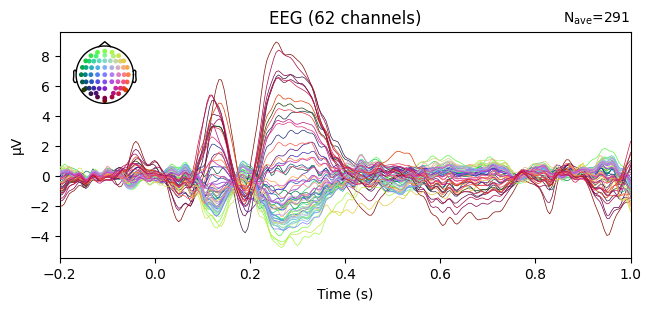

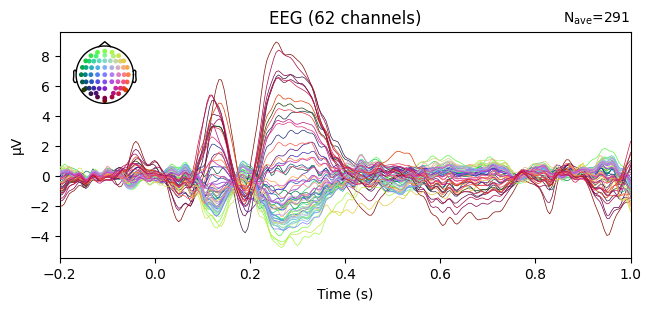

In [67]:
evoked=clean[2].average()
evoked.plot()

In [70]:
# Function to reject and interpolate bad epochs and save drop log to a CSV
def autoreject_epochs(subject, reref_path, clean_path, overwrite):
    """
    Apply AutoReject to clean epochs, save cleaned epochs, and export drop log to a CSV file.

    Parameters:
    - subject: str
        The subject identifier (e.g., 'subject01').
    - reref_path: str
        The path where the rereferenced epochs are stored.
    - clean_path: str
        The path where the cleaned epochs should be saved.
    - overwrite: bool
        Whether to overwrite the existing file.

    Returns:
    - epochs_clean: mne.Epochs
        The cleaned epochs object.
    """

     # Save the drop log as a CSV file
    drop_log_filename = clean_path + subject + '_drop_log.csv'
    if os.path.exists(drop_log_filename) and not overwrite:
       print(f"Autoreject file already exists for {subject}. Skipping autoreject.")
       return None

    # Load epochs file
    ica_epochs = mne.read_epochs(reref_path + subject + 'apply_baseline' + '-epo.fif')

    # Apply AutoReject to the epochs
    ar = AutoReject()
    epochs_clean = ar.fit_transform(ica_epochs)

    # Save cleaned epochs
    clean_epochs_name = subject + 'ar' + '-epo.fif'
    ica_epochs_path = clean_path + clean_epochs_name
    epochs_clean.save(ica_epochs_path, overwrite=overwrite)

    # Extract the drop log from the cleaned epochs
    drop_log = epochs_clean.drop_log

    # Convert the drop log to a DataFrame for easier export to CSV
    drop_log_df = pd.DataFrame({
        'epoch': range(len(drop_log)),
        'drop_reason': [', '.join([reason for reason in log if reason]) if log else 'OK' for log in drop_log]
    })

   
    drop_log_df.to_csv(drop_log_filename, index=False)

    print(f"Drop log saved as {drop_log_filename}")

    return epochs_clean


In [71]:
ar_epochs = [autoreject_epochs(subject, reref_path=baseline_corrected_path, clean_path=ar_epochs_path, overwrite=False) for subject in subs]

Autoreject file already exists for 0104-7VZA0. Skipping autoreject.
Autoreject file already exists for 0110-1IS78. Skipping autoreject.
Autoreject file already exists for 0109-GZN0K. Skipping autoreject.
Autoreject file already exists for 0107-FN3G3. Skipping autoreject.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/baseline_correct_epochs/0128-HBQT4apply_baseline-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
291 matching events found
No baseline correction applied
0 projection items activated
Running autoreject on ch_type=eeg


100%|██████████| Creating augmented epochs : 64/64 [00:01<00:00,   39.35it/s]
100%|██████████| Computing thresholds ... : 64/64 [01:27<00:00,    1.36s/it]



































































































































































































































































































100%|██████████| Repairing epochs : 291/291 [00:05<00:00,   57.19it/s]




































































































































































































































































































100%|██████████| Repairing epochs : 291/291 [00:08<00:00,   35.70it/s]






















100%|██████████| Fold : 10/10 [00:05<00:00,    1.96it/s]















































Estimated consensus=0.40 and n_interpolate=4






































































































































































































































































































100%|██████████| Repairing epochs : 291/291 [00:07<00:00,   36.91it/s]

Dropped 22 epochs: 46, 51, 56, 58, 64, 71, 72, 73, 148, 151, 161, 193, 201, 203, 204, 207, 210, 215, 216, 222, 262, 267


Drop log saved as /Users/admin/Documents/CodingBrain25/PreProcessing/autoreject_epochs/0128-HBQT4_drop_log.csv
Autoreject file already exists for 0122-BJDQI. Skipping autoreject.
Autoreject file already exists for 1217-SFP13. Skipping autoreject.
Autoreject file already exists for 0102-PV1XF. Skipping autoreject.
Autoreject file already exists for 0112-ZGZE5. Skipping autoreject.
Autoreject file already exists for 0108-U5RMG. Skipping autoreject.
Autoreject file already exists for 0114-9GG89. Skipping autoreject.
Autoreject file already exists for 0117-KXKZ2. Skipping autoreject.
Autoreject file already exists for 0104-SZEQ2. Skipping autoreject.
Autoreject file already exists for 0103-XN1WL. Skipping autoreject.
Autoreject file already exists for 0106-TZFW3. Skipping autoreject.
Autoreject file already exists for 0127-jpjw9. Skipping autoreject.


<EpochsFIF | 280 events (all good), -0.2 – 1 s (baseline -0.2 – 0 s), ~33.5 MiB, data loaded,
 'congruent': 206
 'incongruent': 74>


In [79]:
# Function 1: Compute and save individual evoked responses for a single subject
def compute_and_save_evokeds(cleaned_epochs_path, subject, evoked_path):
    # Generate a subject ID
    subject_id = subject

    # Read in cleaned epochs for the subject
    epochs_file = f"{cleaned_epochs_path}/{subject_id}ar-epo.fif"
    epochs = mne.read_epochs(epochs_file, preload=True)
    congruent_filename = evoked_path + subject_id + '_congruent_evoked.csv'
    incongruent_filename = evoked_path + subject_id + '_incongruent_evoked.csv'
    cong_ave_filename = evoked_path + subject_id + '_congruent-ave.fif'
    incong_ave_filename = evoked_path + subject_id + '_incongruent-ave.fif'

    if os.path.exists(congruent_filename) and os.path.exists(incongruent_filename) and os.path.exists(cong_ave_filename) and os.path.exists(incong_ave_filename):
        print(f"Congruent evokeds file already exists for {subject}. Skipping.")
        return None

    # Initialize lists to store evoked responses
    congruent_evoked_list = []
    incongruent_evoked_list = []
    
    # Process the 'congruent' condition
    if 'congruent' in epochs.event_id:
        congruent_evoked = epochs['congruent'].average()
        congruent_evoked_list.append(congruent_evoked)

        # Save evoked to a .fif file
        congruent_evoked.save(f'{evoked_path}/{subject_id}_congruent-ave.fif')

        # Convert the evoked data to a DataFrame
        df_congruent = pd.DataFrame({
            'subject': subject_id,
            'time': congruent_evoked.times,
            'evoked': congruent_evoked.data.mean(axis=0),  # Average across channels
            'condition': 'congruent'
        })
        # Save evoked data to CSV
        df_congruent.to_csv(f'{evoked_path}/{subject_id}_congruent_evoked.csv', index=False)

    # Process the 'incongruent' condition
    if 'incongruent' in epochs.event_id:
        incongruent_evoked = epochs['incongruent'].average()
        incongruent_evoked_list.append(incongruent_evoked)

        # Save evoked to a .fif file
        incongruent_evoked.save(f'{evoked_path}/{subject_id}_incongruent-ave.fif')

        # Convert the evoked data to a DataFrame
        df_incongruent = pd.DataFrame({
            'subject': subject_id,
            'time': incongruent_evoked.times,
            'evoked': incongruent_evoked.data.mean(axis=0),  # Average across channels
            'condition': 'incongruent'
        })
        # Save evoked data to CSV
        df_incongruent.to_csv(f'{evoked_path}/{subject_id}_incongruent_evoked.csv', index=False)

    # Return the individual evoked responses for the subject
    return congruent_evoked_list, incongruent_evoked_list

In [80]:
evoked_data = [compute_and_save_evokeds(cleaned_epochs_path=ar_epochs_path, subject=subject, evoked_path=evoked_path) for subject in subs]

Reading /Users/admin/Documents/CodingBrain25/PreProcessing/autoreject_epochs/0104-7VZA0ar-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Congruent evokeds file already exists for 0104-7VZA0. Skipping.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/autoreject_epochs/0110-1IS78ar-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
265 matching events found
No baseline correction applied
0 projection items activated
Congruent evokeds file already exists for 0110-1IS78. Skipping.
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/autoreject_epochs/0109-GZN0Kar-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices avail

In [83]:


def read_evokeds_and_compute_grand_average(evoked_path, grand_path, subjects, roi, overwrite=True):
    congruent_evoked_list = []
    incongruent_evoked_list = []
    
    # Iterate over each subject to load their evoked responses
    for subject_id in subjects:
        # Load evoked responses from .fif files for congruent and incongruent conditions
        congruent_evoked = mne.read_evokeds(f'{evoked_path}/{subject_id}_congruent-ave.fif')[0]
        incongruent_evoked = mne.read_evokeds(f'{evoked_path}/{subject_id}_incongruent-ave.fif')[0]
        
        # Append the evoked responses to their respective lists
        congruent_evoked_list.append(congruent_evoked)
        incongruent_evoked_list.append(incongruent_evoked)

    # Compute grand average for each condition
    grand_average_congruent = mne.grand_average(congruent_evoked_list)
    grand_average_incongruent = mne.grand_average(incongruent_evoked_list)

    # Define the file paths
    congruent_fif = f'{grand_path}/grand_average_congruent-ave.fif'
    incongruent_fif = f'{grand_path}/grand_average_incongruent-ave.fif'
    comparison_plot_path = f'{grand_path}/grand_average_comparison_plot.png'
    combined_csv_path = f'{grand_path}/grand_average_combined.csv'

    # Overwrite existing files if necessary
    if overwrite:
        if os.path.exists(congruent_fif):
            os.remove(congruent_fif)
        if os.path.exists(incongruent_fif):
            os.remove(incongruent_fif)
        if os.path.exists(comparison_plot_path):
            os.remove(comparison_plot_path)
        if os.path.exists(combined_csv_path):
            os.remove(combined_csv_path)

    # Save grand average evoked responses to .fif files
    grand_average_congruent.save(congruent_fif)
    grand_average_incongruent.save(incongruent_fif)

    # Create a dictionary to pass the grand averages with condition names for labeling
    evokeds = {
        'Congruent': grand_average_congruent,
        'Incongruent': grand_average_incongruent
    }

    # Plot the evoked responses for comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    mne.viz.plot_compare_evokeds(evokeds, picks=roi, combine="mean",
                                 title='Grand Average or N400 and P600 Comparison at Central-Parietal Electrodes ID',
                                 axes=ax, legend=True, vlines=[0.5, 0.7, 0.2, 0.5])
    
    # Save the comparison plot
    plt.savefig(comparison_plot_path)

    # Combine grand average congruent and incongruent into one DataFrame
    df_grand_congruent = pd.DataFrame({
        'subject': 'grand_average',
        'time': grand_average_congruent.times,
        'evoked': grand_average_congruent.data.mean(axis=0),  # Average across channels
        'condition': 'congruent'
    })

    df_grand_incongruent = pd.DataFrame({
        'subject': 'grand_average',
        'time': grand_average_incongruent.times,
        'evoked': grand_average_incongruent.data.mean(axis=0),  # Average across channels
        'condition': 'incongruent'
    })

    # Combine and save grand average to a single CSV
    df_grand_combined = pd.concat([df_grand_congruent, df_grand_incongruent])
    df_grand_combined.to_csv(combined_csv_path, index=False)

    print(f"Grand averages saved in {grand_path}")
    
    # Return the figure for display or further use
    return fig

Reading /Users/admin/Documents/CodingBrain25/PreProcessing/Evokeds/0104-7VZA0_congruent-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms (congruent)
        0 CTF compensation matrices available
        nave = 206 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/Evokeds/0104-7VZA0_incongruent-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms (incongruent)
        0 CTF compensation matrices available
        nave = 74 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
Loaded Evoked data is baseline-corrected (baseline: [-0.2, 0] s)
Reading /Users/admin/Documents/CodingBrain25/PreProcessing/Evokeds/0110-1IS78_congruent-ave.fif ...
    Found the data of interest:
        t =    -200.00 ...   

<Figure size 640x480 with 0 Axes>

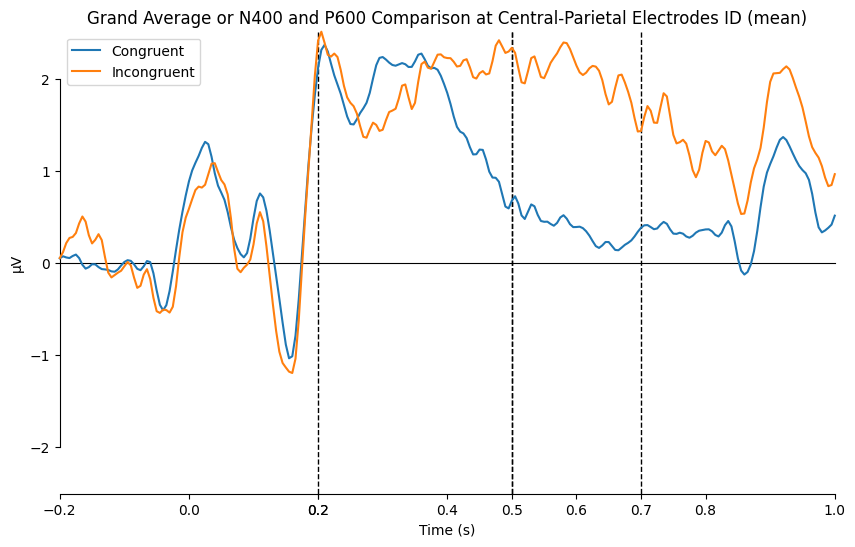

Grand averages saved in /Users/admin/Documents/CodingBrain25/PreProcessing/Grand_average/


In [84]:
# Define your region of interest (ROI), e.g., central-parietal electrodes
# Define the region of interest (ROI) channels
roi = ['Cz', 'Pz', 'CPz', 'C3', 'C4', 'P3', 'P4']

# Read evokeds, compute grand average, and plot
fig = read_evokeds_and_compute_grand_average(evoked_path=evoked_path, grand_path=grand_path, subjects=subs, roi=roi, overwrite=True)
